In [ ]:
import ROOT
from T2KStyle import T2KStyle
c = ROOT.TCanvas('c', '', 800, 600)
cl = ROOT.TCanvas('cl', '', 1600, 1200)
cw = ROOT.TCanvas('c2', '', 1600, 600)

In [2]:
# 0 - desy
# 1 - mm1
# 2 - er2
# 3 - er3

# 4 - DESY cosmic

file = [ROOT.TFile('~/LXPLUS/DESY_testbeam/multi_pad/g_360_200_dedx.root')]
file.append(ROOT.TFile('~/LXPLUS/DESY_testbeam/cosmic_eram/mm1_360V_200ns_dedx.root'))
file.append(ROOT.TFile('~/LXPLUS/DESY_testbeam/cosmic_eram/er2_360V_dedx.root'))
file.append(ROOT.TFile('~/LXPLUS/DESY_testbeam/cosmic_eram/er3_360V_dedx.root'))

# file.append(ROOT.TFile('~/LXPLUS/DESY_testbeam/multi_pad/c_0d_0p2T_200ns_50Mhz_dedx.root'))
file.append(ROOT.TFile('~/LXPLUS/DESY_testbeam/multi_pad/c_0d_0T_200ns_25Mhz_dedx.root'))

name = ['DESY beam', 'MM1', 'ERAM2', 'ERAM3', 'DESY_cosmic', 'DESY_cosmic 2']
color = [ROOT.kBlack, ROOT.kRed, ROOT.kGreen, ROOT.kBlue, ROOT.kViolet, ROOT.kCyan]

In [ ]:
cl.cd()
cl.Clear()
cl.Divide(2, 2)

ROOT.gStyle.SetOptTitle(0)

leg = ROOT.TLegend(0.2,0.2,0.4,0.4);

for i in range(2, 0, -1):
    opt = 'histo' if i == 2 else 'histo same'
    
    cl.cd(1)
    charge = file[i].Get('un_trunc_cluster')
    charge.Scale(1./charge.Integral())
    charge.SetLineColor(color[i])
    charge.SetTitle(name[i])
    charge.GetXaxis().SetTitle('Untrancated charge [a.u.]')
    charge.GetXaxis().SetRangeUser(0., 5000.)
    charge.Draw(opt)
    
    cl.cd(2)
    dedx = file[i].Get('dEdx')
    dedx.Scale(1./dedx.Integral())
    dedx.SetLineColor(color[i])
    dedx.SetTitle(name[i])
    dedx.Draw(opt)
    dedx.GetXaxis().SetTitle('Trancated charge [a.u.]')
    dedx.GetXaxis().SetRangeUser(0., 2000.)
    
    cl.cd(3)
    Mult = file[i].Get('Mult')
    Mult.Scale(1./Mult.Integral())
    Mult.SetLineColor(color[i])
    Mult.SetTitle(name[i])
    Mult.Draw(opt)
    Mult.GetXaxis().SetTitle('Multiplicity')
    
    cl.cd(4)
    leg.AddEntry(Mult, name[i], 'l')
    

cl.Draw()
cl.cd(4)
leg.Draw()
# cl.BuildLegend()    

In [ ]:
cw.Clear()
cw.Divide(2)

cw.cd(1)
angle = file[1].Get('angle')
angle.GetXaxis().SetRangeUser(0., 0.3)
angle.GetYaxis().SetRangeUser(0., 0.3)
angle.GetXaxis().SetTitle('tg(#phi)')
angle.GetYaxis().SetTitle('tg(#theta)')
angle.Draw('colz')

cw.cd(2)
angle = file[2].Get('angle')
angle.GetXaxis().SetRangeUser(0., 0.3)
angle.GetYaxis().SetRangeUser(0., 0.3)
angle.GetXaxis().SetTitle('tg(#phi)')
angle.GetYaxis().SetTitle('tg(#theta)')
angle.Draw('colz')

cw.Draw()

In [ ]:
cw.Clear()
cw.Divide(2)

c.cd()

# cw.cd(1)
# ROOT.gPad.SetLogy()
# ROOT.gPad.SetGrid()
# delta_t_lead = file[1].Get('delta_t_fst')
# delta_t_lead.GetXaxis().SetTitle('t_{lead}-t_{second}')
# delta_t_lead.SetLineColor(ROOT.kRed)
# delta_t_lead.Scale(1./delta_t_lead.Integral())
# delta_t_lead.Draw(' histo')
# print(delta_t_lead.Integral(0, 150) / delta_t_lead.Integral())

# delta_t_lead = file[2].Get('delta_t_fst')
# delta_t_lead.GetXaxis().SetTitle('t_{lead}-t_{second}')
# delta_t_lead.SetLineColor(ROOT.kGreen)
# delta_t_lead.Scale(1./delta_t_lead.Integral())
# delta_t_lead.Draw(' histosame')

c.cd(2)
ROOT.gPad.SetLogy()
ROOT.gPad.SetGrid()
for i in range(5):
    opt = 'histo' if i == 0 else 'histo same'
    delta_t_lead = file[i].Get('delta_t_scd')
    delta_t_lead.GetXaxis().SetTitle('t_{lead}-t_{third} [time bins]')
    delta_t_lead.SetLineColor(color[i])
    delta_t_lead.SetTitle(name[i])
    delta_t_lead.GetXaxis().SetRangeUser(-50., 100.)
    delta_t_lead.Scale(1./delta_t_lead.Integral())
    delta_t_lead.GetYaxis().SetRangeUser(1e-4, 3e-1)
    delta_t_lead.Draw(opt)

ROOT.gPad.BuildLegend()

c.Draw()

In [ ]:
cw.Clear()
cw.Divide(2)

cw.cd(1)
ROOT.gPad.SetLogy()
ROOT.gPad.SetGrid()
delta_t_lead = file[0].Get('delta_t_fst')
delta_t_lead.GetXaxis().SetTitle('t_{lead}-t_{second}')
delta_t_lead.SetLineColor(ROOT.kBlack)
delta_t_lead.Scale(1./delta_t_lead.Integral())
delta_t_lead.Draw(' histo')

cw.cd(2)
ROOT.gPad.SetLogy()
ROOT.gPad.SetGrid()
delta_t_lead = file[0].Get('delta_t_scd')
delta_t_lead.GetXaxis().SetTitle('t_{lead}-t_{third}')
delta_t_lead.SetLineColor(ROOT.kBlack)
delta_t_lead.Scale(1./delta_t_lead.Integral())
delta_t_lead.Draw(' histosame')

cw.Draw()

In [ ]:
c.Clear()
c.cd()
angle = file[0].Get('angle')
angle.GetXaxis().SetRangeUser(0., 0.3)
angle.GetYaxis().SetRangeUser(0., 0.3)
angle.GetXaxis().SetTitle('tg(#phi)')
angle.GetYaxis().SetTitle('tg(#theta)')
angle.Draw('colz')
c.Draw()

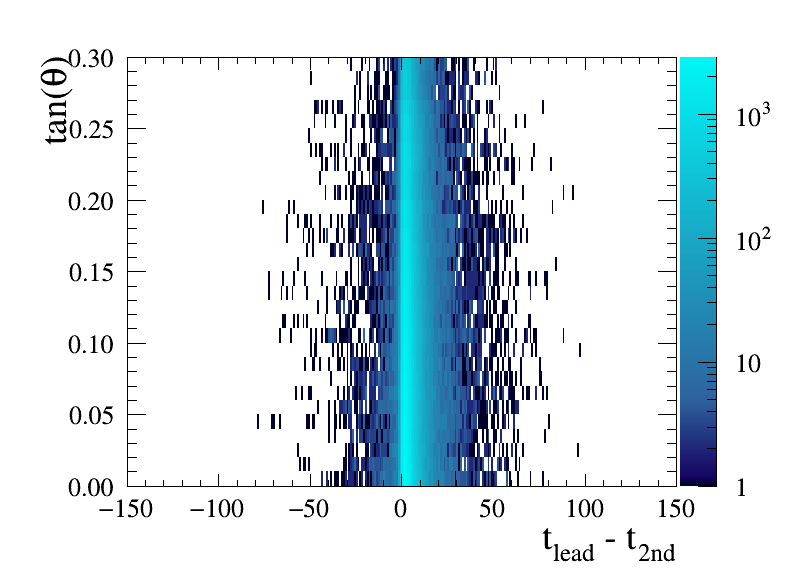

In [16]:
c.Clear()
c.cd()
dt_angle = file[1].Get('dt_angle')
dt_angle.GetYaxis().SetRangeUser(0., 0.3)
dt_angle.GetYaxis().SetTitle('tan(#theta)')
dt_angle.GetXaxis().SetTitle('t_{lead} - t_{2nd}')
dt_angle.Draw('colz')
c.SetLogz()
c.Draw()

In [ ]:
c.Clear()
c.cd()
dt_angle = file[0].Get('dt_angle')
dt_angle.GetYaxis().SetRangeUser(0., 0.3)
dt_angle.Draw('colz')
c.SetLogz()
c.Draw()